# MNIST digit classification: Neural Network

In this notebook, we classify the hand-written digits 0-9, using the famous MNIST dataset. For classification, we implement a multi-layer neural network model

Let's import all the required packages

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

We can import the datasets using torchvision

In [2]:
train_dataset = torchvision.datasets.MNIST(root = './data', 
                                           train = True,                       # training data
                                           transform = transforms.ToTensor(),  # transform
                                           download = True)        # download if not available

test_dataset = torchvision.datasets.MNIST(root = './data', 
                                           train = False,                      # test data
                                           transform = transforms.ToTensor())  # transform

In [3]:
print(train_dataset)
print('----------')
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
----------
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


Training dataset size: 60000
Test dataset size: 10000
Image size and lable: torch.Size([1, 28, 28]) 5


<function matplotlib.pyplot.show(*args, **kw)>

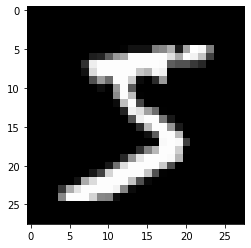

In [4]:
print('Training dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

image, label = train_dataset[0]
print('Image size and lable:', image.size(), label)

plt.imshow(image[0], cmap = 'gray')
plt.show

We have 60,000 images of size 1 * 28 * 28, where 1 is color channel (black and white images) and images are of size 28 * 28.
<br>Now, let's look at the barchart of classes to ascertain whether this is a balanced or unbalanced dataset.

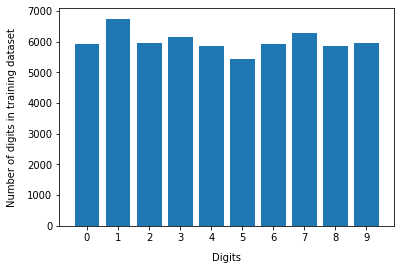

In [5]:
digit_count = np.zeros(10)

for i in range(len(train_dataset)):
    image, label = train_dataset[i];
    digit_count[label] += 1

digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

plt.bar(digits, digit_count)
plt.xlabel('Digits', labelpad = 10)
plt.ylabel('Number of digits in training dataset', labelpad = 10)
plt.xticks(np.arange(0, 10, 1))
plt.show()

The dataset is balanced, with the number of examples nearly equal for all classes.

Now, let's define the dataloaders objects for batch training

In [6]:
batch_size = 100     # batch size for batch training

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = batch_size,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)         # does not matter on test data

Let's have a look at one batch of this data and few of the images

torch.Size([100, 1, 28, 28]) torch.Size([100])


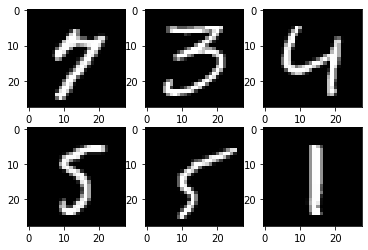

In [7]:
test_iter = iter(train_loader)
samples, labels = test_iter.next()
print(samples.shape, labels.shape)    # outputs [100, 1, 28, 28]: 100 examples, 1 color channel, 28 * 28 images

for i in range(6):
    plt.subplot(2, 3, i+1)                        # 2 rows, 3 columns
    plt.imshow(samples[i][0], cmap = 'gray')
plt.show()

## Model and Training

First, lets define the model we want to train. Our model is a fully connected neural network with one hidden layer

In [8]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_classes):     # n_classes is the output size       
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x):
        out = torch.relu(self.layer1(x))
        out = self.layer2(out)
        return out

Now, we train the model

In [9]:
input_size = 784                # images are 28 * 28
hidden_size = 100
n_classes = 10
learning_rate = 0.001

model = NeuralNet(input_size, hidden_size, n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_epochs = 20
n_batches = len(train_loader)

accuracy_epoch = []
counter_epoch = []

for epoch in range(n_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.reshape(-1, 28*28).to(device)   # reshaping 100*1*28*28 to 100, 784
        labels = labels.to(device)                      # to(device) pushes it to gpu if available 
        
        outputs = model(images)                 # forward pass
        loss = criterion(outputs, labels)       # loss computation                        
        loss.backward()                         # back propagation
        optimizer.step()                        # parameters update
        optimizer.zero_grad()                   
        
        #if (i+1) % 100 == 0:
        #    print(f'epoch: {epoch+1}/{n_epochs}; batch: {i+1}/{n_batches}; loss: {loss.item():.4f}')
            
    with torch.no_grad():    # test
            
        n_correct = 0
        n_samples = 0
            
        for images, labels in test_loader:
                
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
                
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # returns value, index: our interest is only index
            n_correct += (predictions == labels).sum().item()
            n_samples += labels.shape[0]            # number of samples in current batch
                
        accuracy = 100.0 * n_correct / n_samples
        accuracy_epoch.append(accuracy)
        counter_epoch.append(epoch+1)
        print(f'epoch: {epoch+1}/{n_epochs}; accuracy = {accuracy}')

epoch: 1/20; accuracy = 93.33
epoch: 2/20; accuracy = 95.39
epoch: 3/20; accuracy = 96.35
epoch: 4/20; accuracy = 96.86
epoch: 5/20; accuracy = 96.98
epoch: 6/20; accuracy = 97.36
epoch: 7/20; accuracy = 97.39
epoch: 8/20; accuracy = 97.53
epoch: 9/20; accuracy = 97.53
epoch: 10/20; accuracy = 97.65
epoch: 11/20; accuracy = 97.63
epoch: 12/20; accuracy = 97.62
epoch: 13/20; accuracy = 97.69
epoch: 14/20; accuracy = 97.5
epoch: 15/20; accuracy = 97.76
epoch: 16/20; accuracy = 97.72
epoch: 17/20; accuracy = 97.7
epoch: 18/20; accuracy = 97.54
epoch: 19/20; accuracy = 97.66
epoch: 20/20; accuracy = 97.81


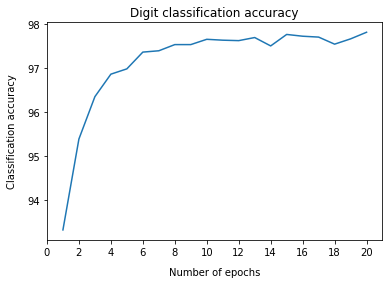

In [10]:
plt.plot(counter_epoch, accuracy_epoch)
plt.title('Digit classification accuracy')
plt.xlabel('Number of epochs', labelpad = 10)
plt.ylabel('Classification accuracy', labelpad = 10)
plt.xticks(np.arange(min(counter_epoch)-1, max(counter_epoch)+1, 2))
plt.show()

Without any extensive hyperparameter tuning, our neural network with one hidden layer (100 neurons), is able to recognize digits with nearly 98% accuracy.

Further directions to improve the accuracy could be:
 - A systematic hyperparameter tuning
 - Trying multi-layer neural networks
 - More data: 60,000 examples are not good enough to develop deep learning models